# **Miniproject 2**
## **~Large~ Small Language Model**

### **Objective**
Implement a transformer-based, character-level language model (GPT-like) and train it on the Shakespeare dataset. By the end of this project, you should be able to generate Shakespearean-like text given a seed string.

You will probably want to train the model on a GPU. You can use free GPUs on [Google Colab](https://colab.research.google.com/?utm_source=scs-index).

### **Dataset**:

The Shakespeare dataset contains the complete works of William Shakespeare, including his plays, poems, and sonnets.

[**Download link**](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In a character-level language model, each character in the input data is mapped to its respective index from a dictionary. The input to the model is in the form (B, N), where B is the batch size and N is the number of tokens for each sequence. The model was tested with B=N=128, but feel free to explore different values.

An interface for the dataset class that takes care of tokenization is provided below.



```python
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass
```




### **Requirements**

#### **Architecture**

Implement the Transformer's decoder-only structure.
This includes

* input token embeddings
* the causal multi-head self-attention mechanism
* feed-forward neural networks
* positional encodings, residual connections, layer normalizations.

The project was tested with $12$ layers, $8$ attention heads, and $768$ embedding dimensions, on a single GPU.

The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---

#### **Training**

In a character-level transformer language model, the goal is to predict the next character in a sequence given the previous characters. To train such a model effectively, we use two versions of our data: the input sequence and a shifted version of this sequence, which serves as the target for our predictions.

Preprocess the dataset to a character-level representation.
Use a sliding window approach for sequence chunks (e.g., window size of $128$ characters).
Implement causal masking for the self-attention mechanism.
Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer and the cross-entropy loss.

**Optional**:

* Implement a learning rate decay strategy
* Implement gradient clipping

---


#### **Evaluation and Inference**

* Monitor the cross-entropy loss. Use a seed string to initialize the model and generate Shakespearean-like text.

* In order to generate the characters, at each generation step you can either select the character with the highest probability, or you can sample according to the output distribution.

The high-level pseudocode for generation is:

```python
model.eval()
with torch.no_grad():
    context = "O God, O God!"
    tokenized_context = tokenize(context)
    # the model should implement a method to generate tokens given a prompt
    y = model.generate(tokenized, ...)
    completion = tokens_to_string(y)
```

**Optional**:
* Compute the [perplexity](https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72#:~:text=Intuitively%2C%20perplexity%20means%20to%20be,loss%20obtained%20from%20the%20model.) metric for quantitative evaluation.

### **Example Outputs**

The following are my outputs after $6000$ steps of training, with the seed string "O God, O God!"



```
O God, O God! neither? unto the base very ears,
As damned with it.

DUKE OF YORK:
Away! Once more, one word.

RICHARD:
Clove, dear so; and therein my son will be
false of woe: if ye seems to be the mother
Of gracious order this time when R going kinsperse eyes,
What dost bewreck her fairer drying tears.

NORTHUMBERLAND:
Have you forgot the Duke of Norfolk, get him to
again; and and agilic: there is my spirit
So maly did must such a marble perfection.

ELBOW:
Come, bring them with oaths, and so deliver
```


### Resources:

* Vaswani et al., "Attention is All You Need": [link](https://arxiv.org/abs/1706.03762)

* Illustrated Transformer by Jay Alammar: [link](https://jalammar.github.io/illustrated-transformer/)

* OpenAI GPT-2 Paper: [link](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

* Deep Learning Course slides on transformers: [link](https://fleuret.org/dlc/materials/dlc-handout-13-3-transformers.pdf)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
class Config:
    def __init__(self):
        self.block = 128
        self.batch = 128
        self.epochs = 15
        self.num_heads = 8
        self.lr = 0.00008
        self.embed_dim = 768
        self.num_layers = 12
        self.dropout = 0.1
        self.seed = 42
        self.device = torch.device("cuda") #if torch.cuda.is_available() else "cpu"
        self.data_size = 0
        self.vocab_size = 0

config = Config()

class CharDataset(Dataset):
    """
    Emits batches of tokens.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):
        self.config = config


        tokens =  sorted(list(set(data))) # get tokens from the input data
        self.stoi =  { ch:i for i,ch in enumerate(tokens) } # map tokens to integer indices
        self.itos =  { i:ch for i,ch in enumerate(tokens) } # map integer indices to tokens
        self.data = data
        self.data_size = len(data)
        self.vocab_size = len(tokens)


    def get_vocab_size(self):
        return self.vocab_size

    def __len__(self):
        return len(self.data) // self.config.block

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) tokens from the data
        # encode every token to an integer
        # return the chunk and the shifted version as tensors
        chunk = self.data[idx * self.config.block : (idx + 1) * self.config.block + 1]
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [3]:
text = open("input.txt").read()
dataset = CharDataset(config, text)

print(f"Dataset size: {len(dataset)}")
print(f"Vocab size: {dataset.get_vocab_size()}")

Dataset size: 8714
Vocab size: 65


<!-- multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
attn_output, attn_output_weights = multihead_attn(query, key,value) -->

In [4]:
class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(CausalSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        seq_len_0 = x.size(0)
        # print("Sequence Length:", seq_len)
        self.causal_mask = torch.triu(torch.ones(seq_len_0, seq_len_0), diagonal=1).bool().to(x.device)

        attn_output, _ = self.attention(x, x, x, attn_mask=self.causal_mask)
        return attn_output #self.dropout(attn_output)


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.ca = CausalSelfAttention(embed_dim, num_heads, dropout)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_dim),
            nn.GELU(),
            nn.Linear(ff_hidden_dim, embed_dim)
        )
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.ca(self.layer_norm1(x))

        # Feed-forward with residual connection
        x = x + self.feed_forward(self.layer_norm2(x))

        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, block_size, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, embed_dim * 4, dropout)
            for _ in range(num_layers)
        ])
        self.final_layer_norm  = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.block_size = block_size

    def forward(self, idx):
        # Embedding and position embedding
        tok_emb = self.token_embedding(idx)
        pos = torch.arange(idx.size(1), device=idx.device).unsqueeze(0)
        pos_emb = self.position_embedding(pos)

        # Adding positional information
        x = self.dropout(tok_emb + pos_emb)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Output layer normalization and language model head
        x = self.final_layer_norm(x)
        logits = self.lm_head(x)

        return logits

    # def generate(self, tokenized_context, max_len, temperature=0.8,  sampling=False, top_k=None):
    #     """
    #     Generate text from a trained model using successive blocks of size `block_size`.

    #     Parameters:
    #     - context: Seed string for generation.
    #     - max_len: Total number of tokens to generate.
    #     - sampling: If True, sample the next token based on probabilities. Otherwise, use the highest probability.
    #     - top_k: If not None, only consider the top k most probable tokens for sampling.

    #     Returns:
    #     - Generated indices
    #     """
    #     device = next(self.parameters()).device
    #     generated = tokenized_context
    #     context_tensor = torch.tensor(tokenized_context, dtype=torch.long).unsqueeze(0).to(device)


    #     for _ in range(max_len):
    #         # Crop the context to the last `block_size` tokens if it exceeds the limit
    #         if context_tensor.size(1) > self.block_size:
    #             context_tensor = context_tensor[:, -self.block_size:]

    #         # Forward pass to get logits
    #         logits = self(context_tensor)
    #         logits = logits[:, -1, :]  # Take logits for the last token only
    #         logits = logits / temperature  # Apply temperature scaling

    #         if top_k is not None:
    #             # Apply top-k sampling
    #             top_k_values, top_k_indices = torch.topk(logits, k=top_k)
    #             probs = torch.nn.functional.softmax(top_k_values, dim=-1)
    #             next_token = torch.multinomial(probs, num_samples=1).item()
    #             next_token_index = top_k_indices[next_token]
    #             next_token_tensor = torch.tensor([[next_token_index]], device=device)
    #             context_tensor = torch.cat((context_tensor, next_token_tensor), dim=1)
    #             continue

    #         probs = torch.nn.functional.softmax(logits, dim=-1)

    #         # Decide the next token
    #         if sampling:
    #             next_token = torch.multinomial(probs, num_samples=1).item()
    #         else:
    #             next_token = torch.argmax(probs).item()

    #         # Add the next token to the sequence
    #         generated.append(next_token)
    #         next_token_tensor = torch.tensor([[next_token]], device=device)
    #         context_tensor = torch.cat((context_tensor, next_token_tensor), dim=1)

    #         # Stop if we've generated enough tokens
    #         if context_tensor.size(1) >= max_len:
    #             break

    #     return torch.tensor(generated)

    @torch.no_grad()
    def generate(self, tokenized_context, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Generate text from a trained model using token indices.

        Parameters:
        - tokenized_context: LongTensor of shape (1, t), initial context (sequence of indices).
        - max_new_tokens: Number of tokens to generate.
        - temperature: Controls randomness in sampling; lower values make predictions more deterministic.
        - do_sample: If True, sample from the probability distribution; otherwise, use greedy decoding.
        - top_k: If not None, restrict sampling to top-k most probable tokens.

        Returns:
        - LongTensor of shape (1, t + max_new_tokens) with the generated indices.
        """
        device = next(self.parameters()).device  # Get the model's device
        idx = torch.tensor(tokenized_context, dtype=torch.long).unsqueeze(0).to(device)  # Shape (1, t)

        for _ in range(max_new_tokens):
            # Crop the context to the last block_size tokens if necessary
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # Forward pass to get logits
            logits = self(idx_cond)  # Shape (1, seq_len, vocab_size)
            logits = logits[:, -1, :] / temperature  # Focus on the last token and apply temperature scaling

            # Optionally apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, top_k, dim=-1)
                logits[logits < v[:, [-1]]] = -float('Inf')  # Mask probabilities outside the top-k

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Decide the next token
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)  # Sample from probabilities
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)  # Greedy decoding (most probable token)

            # Append the predicted token to the sequence
            idx = torch.cat((idx, idx_next), dim=1)  # Update the sequence with the new token

        return  idx.squeeze(0)




In [5]:
#
dataloader = DataLoader(dataset, batch_size=config.batch, shuffle=True)

#
model = TransformerLanguageModel(
    vocab_size=dataset.get_vocab_size(),
    embed_dim=config.embed_dim,
    num_heads=config.num_heads,
    num_layers=config.num_layers,
    block_size=config.block,
    dropout=config.dropout
).to(config.device)

optimizer = optim.Adam(model.parameters(), lr=config.lr)
loss_fn = nn.CrossEntropyLoss()

avg_loss = []
# Training loop
for epoch in range(config.epochs):
    model.train()
    total_loss = 0

    for x, y in dataloader :

        x = x.to(config.device) # Move x to the device
        y = y.to(config.device) # Move y to the device

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)

        #
        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()

        #
        optimizer.step()
        total_loss += loss.item()

    # Compute avg loss
    avg_loss.append(total_loss / len(dataloader))
    print(f"Epoch {epoch + 1}/{config.epochs}, Loss: {(total_loss / len(dataloader)):.4f}")


Epoch 1/15, Loss: 2.6655
Epoch 2/15, Loss: 2.4884
Epoch 3/15, Loss: 2.4768
Epoch 4/15, Loss: 2.4711
Epoch 5/15, Loss: 2.4668
Epoch 6/15, Loss: 2.4642
Epoch 7/15, Loss: 2.4621
Epoch 8/15, Loss: 2.4602
Epoch 9/15, Loss: 2.4586
Epoch 10/15, Loss: 2.4568
Epoch 11/15, Loss: 2.4566
Epoch 12/15, Loss: 2.4546
Epoch 13/15, Loss: 2.4533
Epoch 14/15, Loss: 2.4524
Epoch 15/15, Loss: 2.4515


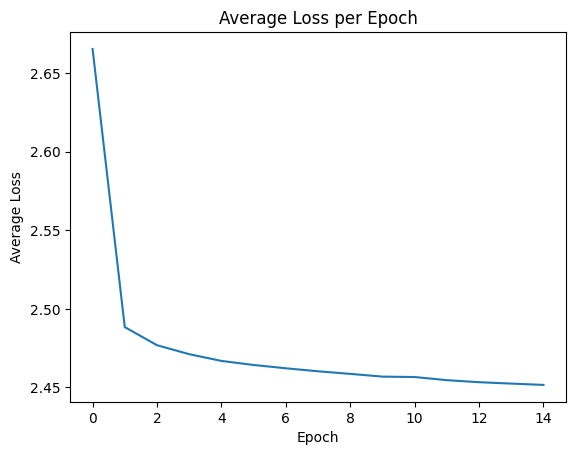

In [6]:
import matplotlib.pyplot as plt
#plotting the avg loss
plt.plot(avg_loss)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.show()

In [7]:
def tokens_to_string(tokens, itos):
    """
    Convert a sequence of tokens to a string.

    Args:
    - tokens (torch.Tensor): Sequence of tokens.
    - itos (dict): Integer-to-string mapping.

    Returns:
    - String representation of the tokens.
    """
    return ''.join([itos[idx] for idx in tokens.tolist()])


def tokenize(text):
    """
    Convert a string to a list of token indices.

    Parameters:
    - text: String to be tokenized.

    Returns:
    - List of token indices.
    """
    return [dataset.stoi[c] for c in text]

In [8]:
itos = dataset.itos

model.eval()
with torch.no_grad():
    context = "O God, O God!"
    tokenized_context = tokenize(context)
    # the model should implement a method to generate tokens given a prompt
    y = model.generate(tokenized_context, max_new_tokens=6000, temperature=1.0, do_sample=True, top_k=10)
    completion = tokens_to_string(y, itos)

print("Generated text:")
print()
print(completion)

Generated text:

O God, O God!
WI t,
HAnd baveno tot od mardourerencon, tire id hamot weth ay derithinet ad my blicatha may?

My t t w fa diro ou hed se whe he w or d men w sthell forars and, s te me ane bouro malore m mar s ancid ser hange by an ore m ay d d ate, hone fr thelowis hedssese st our hee s deanon anoro h beron,
Hooulowno trot wes f wisasinon ate sinsssulim ou he m hor omord sas hinonousound d se, wear hendithee artarthan, t ome st fr st de s hodeses toullthedod,
Taver f has the t a wind w ator ou bu by d h ainthieloore tomugesathat wed wisatand arethanore alaran thens,


APELAns s w hithe d f t the t ou t t aras t se dead.
Bendo d horingisinoun henore aile h baveea d hat.
Seresouno wor shere avon f w torerd s a m ayeanor d bly! ooor t sor,
CI hof t thr aroft ararince m ho ht tithy ha ourery bofathe th wis wioure hou th, m w tr blle me tisthang hondo f wincot wid ade or t houl be t, my
ARDWh, therer f big me beaid a mars ho tho thengain ses myof thy hinsinont t d
Thound far